# Data Cubes & Tensors Demonstration

## Computational Geospatial Analysis - Multi-Dimensional Data Processing
This notebook is a pilot to demonstrate the uses of datacubes and tensors, with use cases for the models' functionality  
 (i.e. `cubes.py` and `tensors.py`)  

with main sections:

1. **Section 1: Raster Data Cubes (Xarray)** - Loading, exploring, and analyzing spatio-temporal rainfall data cubes
2. **Section 2: Raster Cube + Vector Interaction** - Computing zonal statistics using GeoPandas
3. **Section 3: Tensor Operations (PyTorch)** - Converting rasters to tensors and applying convolution

---
# Section 1: Raster Data Cubes (Xarray)
---

## 1.1 Setup and Imports

In [15]:
# Setup path and imports
import sys
sys.path.insert(0, '../src')

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon
import warnings
warnings.filterwarnings('ignore')

# Import from src modules
from _02_processing.cubes import GeospatialCube, create_flood_cube
from _02_processing.tensors import (
    create_geospatial_tensor, 
    normalize_tensor, 
    apply_convolution,
    calculate_tensor_statistics
)

# PyTorch for tensor operations
import torch
import torch.nn.functional as F

plt.rcParams['figure.figsize'] = (12, 5)
print("All imports successful")

All imports successful


## 1.2 Load Rainfall Data Cube

Load the rainfall datacube as an `xarray.Dataset` with explicit dimensions: **time**, **latitude**, **longitude**

In [16]:
# Load rainfall datacube from netCDF (with fallback to synthetic data)
rainfall_path = '../data/processed/rainfall_datacube_aoi.nc'

try:
    rainfall_cube = xr.open_dataset(rainfall_path, engine='netcdf4')
    print(f"Loaded rainfall data from: {rainfall_path}")
except Exception as e:
    print(f"Could not load file: {e}")
    print("Creating synthetic rainfall datacube for demonstration...")
    
    # Create synthetic spatio-temporal rainfall data
    from scipy.ndimage import gaussian_filter
    np.random.seed(42)
    
    time_steps = 84  # 7 years monthly
    lat_size, lon_size = 50, 50
    
    # Generate realistic rainfall patterns
    base_rainfall = np.random.gamma(shape=2, scale=15, size=(time_steps, lat_size, lon_size))
    rainfall_values = gaussian_filter(base_rainfall, sigma=1.5)
    
    # Create xarray Dataset
    time = pd.date_range('2018-01-01', periods=time_steps, freq='MS')
    lat = np.linspace(15.5, 16.3, lat_size)
    lon = np.linspace(32.4, 33.2, lon_size)
    
    rainfall_cube = xr.Dataset(
        {'precipitation': (['time', 'latitude', 'longitude'], rainfall_values)},
        coords={'time': time, 'latitude': lat, 'longitude': lon}
    )
    print("Synthetic datacube created successfully")

# Display dataset structure
print("\nRAINFALL DATA CUBE STRUCTURE")
print(rainfall_cube)

print("\nDimensions:", dict(rainfall_cube.dims))
print("\nCoordinates:")
for coord in rainfall_cube.coords:
    vals = rainfall_cube.coords[coord].values
    if np.issubdtype(vals.dtype, np.datetime64):
        print(f"  {coord}: [{vals.min()}, {vals.max()}]")
    else:
        print(f"  {coord}: [{vals.min():.4f}, {vals.max():.4f}]")

print("\nData variables:")
for var in rainfall_cube.data_vars:
    print(f"  {var}: {rainfall_cube[var].shape}")

Could not load file: [Errno -51] NetCDF: Unknown file format: 'd:\\Master\\Q2\\sci Programming for Geospatial\\Project 2\\flood-exposure-geospatial-pipeline\\data\\processed\\rainfall_datacube_aoi.nc'
Creating synthetic rainfall datacube for demonstration...
Synthetic datacube created successfully

RAINFALL DATA CUBE STRUCTURE
<xarray.Dataset> Size: 2MB
Dimensions:        (time: 84, latitude: 50, longitude: 50)
Coordinates:
  * time           (time) datetime64[us] 672B 2018-01-01 ... 2024-12-01
  * latitude       (latitude) float64 400B 15.5 15.52 15.53 ... 16.27 16.28 16.3
  * longitude      (longitude) float64 400B 32.4 32.42 32.43 ... 33.18 33.2
Data variables:
    precipitation  (time, latitude, longitude) float64 2MB 27.6 28.81 ... 38.38

Dimensions: {'time': 84, 'latitude': 50, 'longitude': 50}

Coordinates:
  time: [2018-01-01T00:00:00.000000, 2024-12-01T00:00:00.000000]
  latitude: [15.5000, 16.3000]
  longitude: [32.4000, 33.2000]

Data variables:
  precipitation: (84, 50, 50)

## 1.3 Temporal Aggregations

Demonstrate key temporal operations on the data cube:
1. **Mean rainfall** - Average precipitation over time
2. **Extreme rainfall (95th percentile)** - High-intensity events
3. **Coefficient of Variation** - Rainfall variability

Mean Rainfall: shape=(50, 50), range=[28.70, 31.55] mm
95th Percentile: shape=(50, 50), range=[30.64, 37.23] mm
CV: shape=(50, 50), range=[0.03, 0.12]


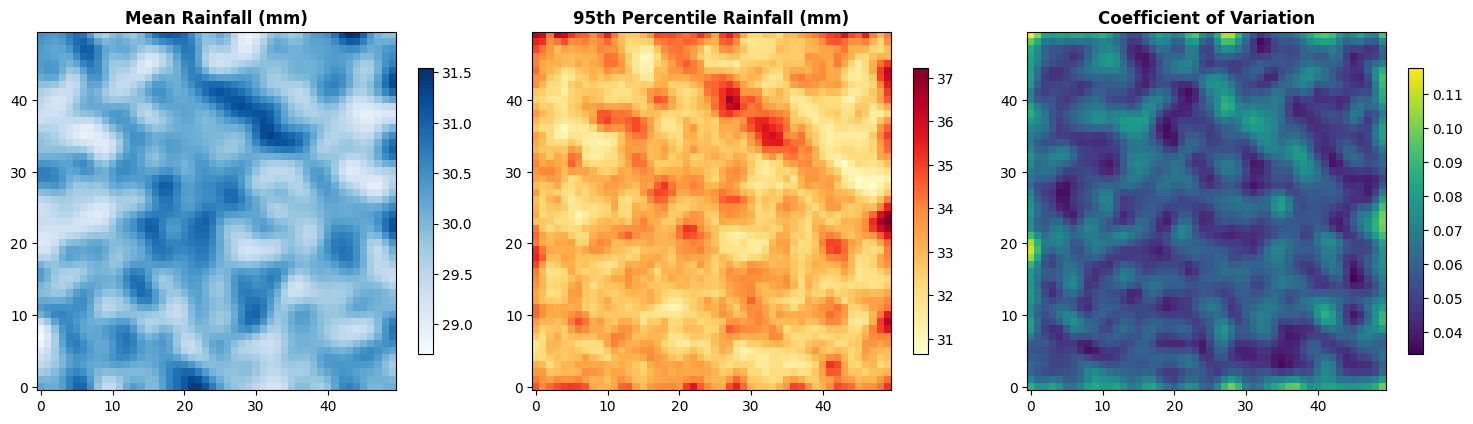

In [17]:
# Get precipitation variable
precip_var = list(rainfall_cube.data_vars)[0]
precip = rainfall_cube[precip_var]

# 1. Mean rainfall (temporal average)
mean_rainfall = precip.mean(dim='time')
print(f"Mean Rainfall: shape={mean_rainfall.shape}, range=[{float(mean_rainfall.min()):.2f}, {float(mean_rainfall.max()):.2f}] mm")

# 2. Extreme rainfall (95th percentile)
extreme_rainfall = precip.quantile(0.95, dim='time')
print(f"95th Percentile: shape={extreme_rainfall.shape}, range=[{float(extreme_rainfall.min()):.2f}, {float(extreme_rainfall.max()):.2f}] mm")

# 3. Coefficient of Variation (std/mean)
std_rainfall = precip.std(dim='time')
cv_rainfall = std_rainfall / (mean_rainfall + 1e-8)
print(f"CV: shape={cv_rainfall.shape}, range=[{float(cv_rainfall.min()):.2f}, {float(cv_rainfall.max()):.2f}]")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(mean_rainfall.values, cmap='Blues', origin='lower')
axes[0].set_title('Mean Rainfall (mm)', fontweight='bold')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(extreme_rainfall.values, cmap='YlOrRd', origin='lower')
axes[1].set_title('95th Percentile Rainfall (mm)', fontweight='bold')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(cv_rainfall.values, cmap='viridis', origin='lower')
axes[2].set_title('Coefficient of Variation', fontweight='bold')
plt.colorbar(im3, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.show()

## 1.4 Spatio-Temporal Slicing

Demonstrate slicing operations:
1. **Single year extraction** - One year of data
2. **Multi-year comparison** - Compare different time periods
3. **Spatial subsetting** - Extract a region of interest

Full time range: 2018-01-01 00:00:00 to 2024-12-01 00:00:00
2019 slice: (12, 50, 50), mean=30.05 mm
2018-2020 slice: (36, 50, 50), mean=30.03 mm
Spatial subset: (84, 50, 50) -> (84, 24, 24)


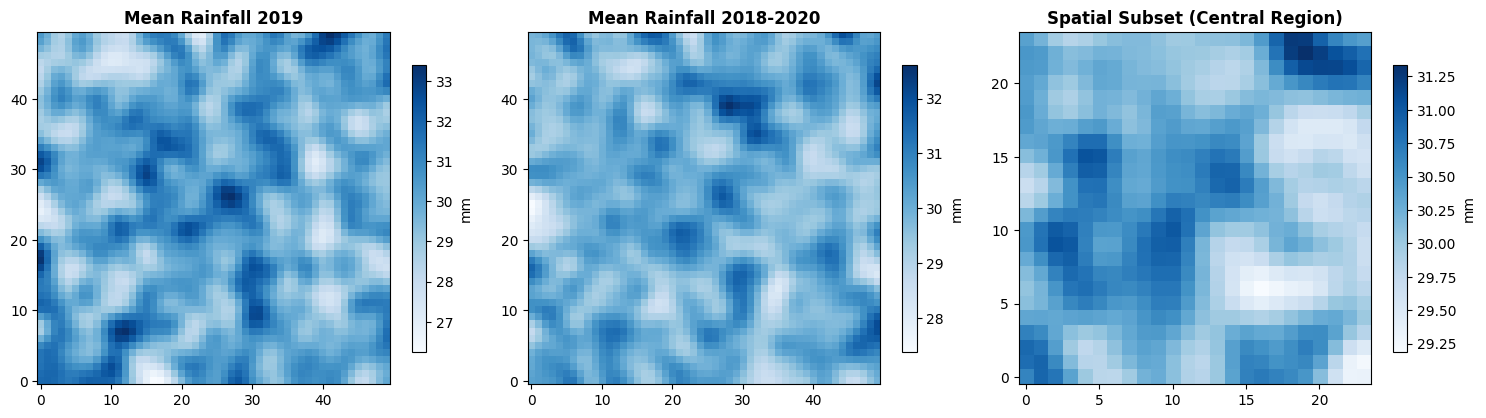

In [18]:
# Get time range
time_coords = pd.to_datetime(precip.time.values)
print(f"Full time range: {time_coords.min()} to {time_coords.max()}")

# 1. Single year (2019)
precip_2019 = precip.sel(time=slice('2019-01-01', '2019-12-31'))
print(f"2019 slice: {precip_2019.shape}, mean={float(precip_2019.mean()):.2f} mm")

# 2. Multi-year (2018-2020)
precip_multi = precip.sel(time=slice('2018-01-01', '2020-12-31'))
print(f"2018-2020 slice: {precip_multi.shape}, mean={float(precip_multi.mean()):.2f} mm")

# 3. Spatial subset
lat_dim = 'latitude' if 'latitude' in precip.coords else 'lat'
lon_dim = 'longitude' if 'longitude' in precip.coords else 'lon'
lat_coords = precip[lat_dim].values
lon_coords = precip[lon_dim].values

lat_subset = (lat_coords.min() + (lat_coords.max()-lat_coords.min())*0.25, 
              lat_coords.min() + (lat_coords.max()-lat_coords.min())*0.75)
lon_subset = (lon_coords.min() + (lon_coords.max()-lon_coords.min())*0.25,
              lon_coords.min() + (lon_coords.max()-lon_coords.min())*0.75)

precip_spatial = precip.sel({lat_dim: slice(*lat_subset), lon_dim: slice(*lon_subset)})
print(f"Spatial subset: {precip.shape} -> {precip_spatial.shape}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(precip_2019.mean(dim='time').values, cmap='Blues', origin='lower')
axes[0].set_title('Mean Rainfall 2019', fontweight='bold')
plt.colorbar(im1, ax=axes[0], shrink=0.8, label='mm')

im2 = axes[1].imshow(precip_multi.mean(dim='time').values, cmap='Blues', origin='lower')
axes[1].set_title('Mean Rainfall 2018-2020', fontweight='bold')
plt.colorbar(im2, ax=axes[1], shrink=0.8, label='mm')

im3 = axes[2].imshow(precip_spatial.mean(dim='time').values, cmap='Blues', origin='lower')
axes[2].set_title('Spatial Subset (Central Region)', fontweight='bold')
plt.colorbar(im3, ax=axes[2], shrink=0.8, label='mm')

plt.tight_layout()
plt.show()

## 1.5 Time Series Analysis

Visualize rainfall trends over time through aggregation along spatial dimensions.

Time series: 84 values, mean=30.06 mm


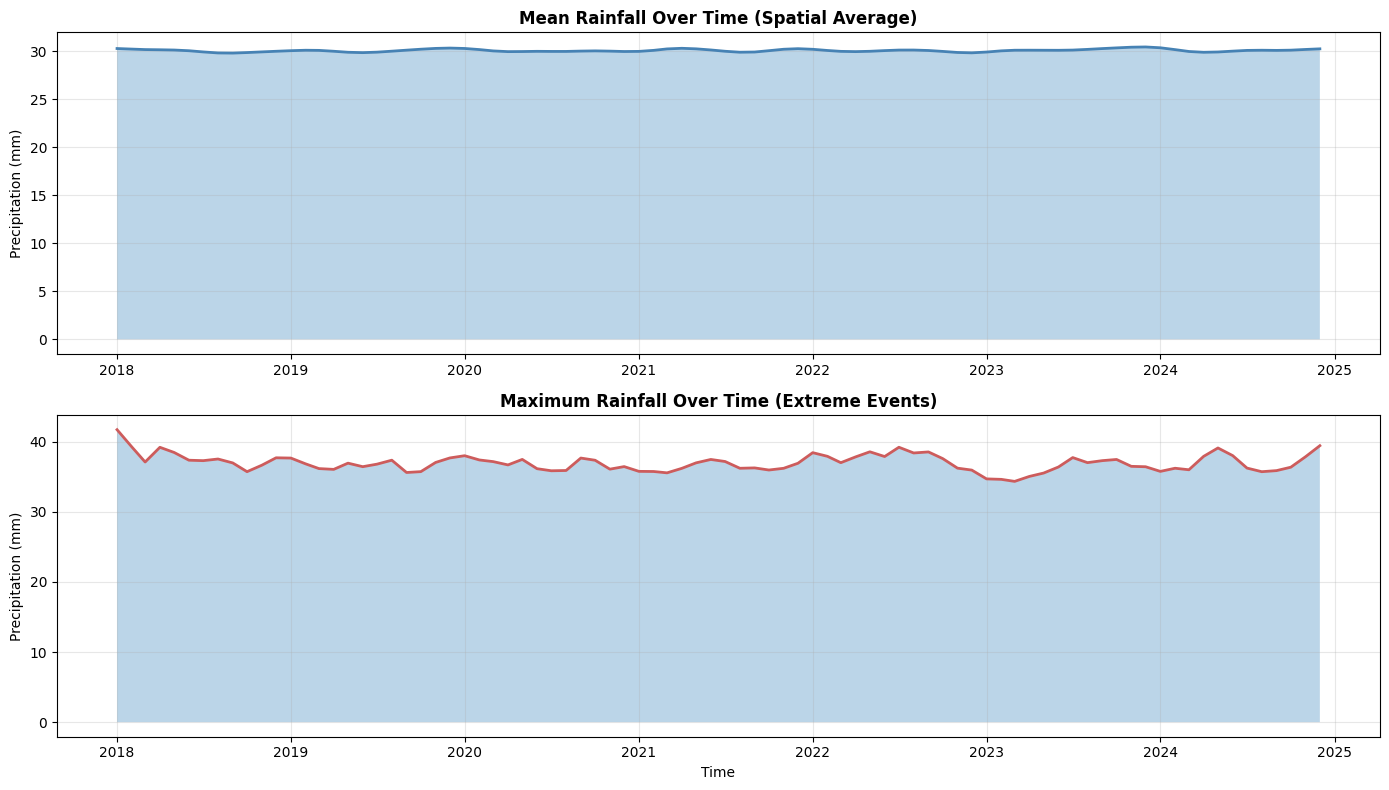

In [19]:
# Spatial aggregation - time series
spatial_dims = [lat_dim, lon_dim]
time_series_mean = precip.mean(dim=spatial_dims)
time_series_max = precip.max(dim=spatial_dims)

print(f"Time series: {len(time_series_mean)} values, mean={float(time_series_mean.mean()):.2f} mm")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(time_series_mean.time, time_series_mean.values, linewidth=2, color='steelblue')
axes[0].fill_between(time_series_mean.time.values, 0, time_series_mean.values, alpha=0.3)
axes[0].set_ylabel('Precipitation (mm)')
axes[0].set_title('Mean Rainfall Over Time (Spatial Average)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_series_max.time, time_series_max.values, linewidth=2, color='indianred')
axes[1].fill_between(time_series_max.time.values, 0, time_series_max.values, alpha=0.3)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Precipitation (mm)')
axes[1].set_title('Maximum Rainfall Over Time (Extreme Events)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Section 2: Raster Cube + Vector Interaction
---

## 2.1 Zonal Statistics with GeoPandas

Compute mean rainfall per polygon zone using the data cube + vector integration.

Zonal Statistics:
zone_id zone_name  mean_rainfall  max_rainfall  pixel_count
     NW Northwest      30.057805     31.070357          625
     NE Northeast      30.048208     31.546557          625
     SW Southwest      30.133916     31.419926          625
     SE Southeast      30.006685     31.180970          625


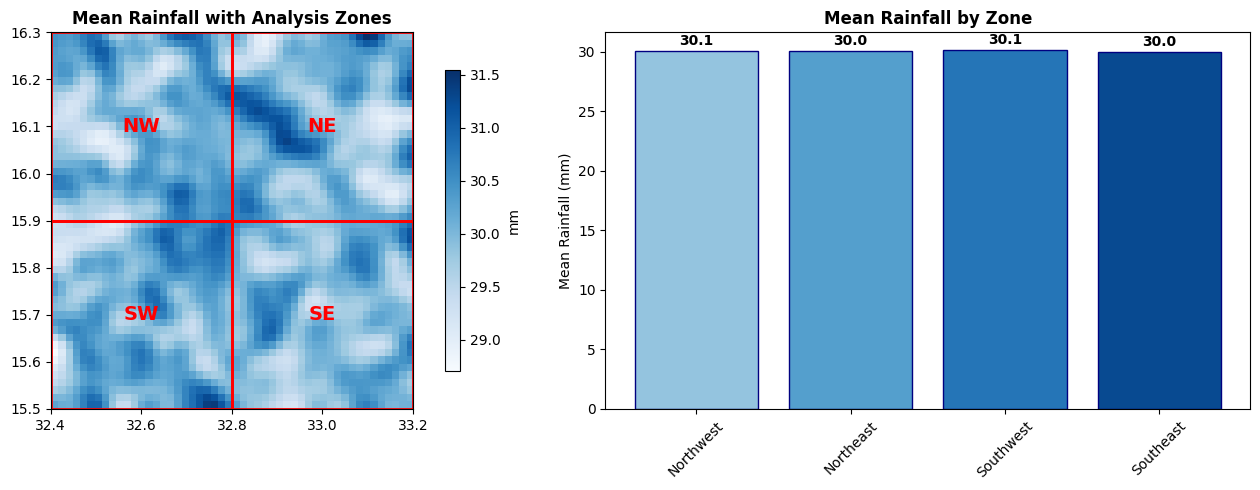

In [20]:
# Create 4 quadrant zones for zonal statistics
lat_coords = precip[lat_dim].values
lon_coords = precip[lon_dim].values
lat_mid = (lat_coords.min() + lat_coords.max()) / 2
lon_mid = (lon_coords.min() + lon_coords.max()) / 2

zones = gpd.GeoDataFrame({
    'zone_id': ['NW', 'NE', 'SW', 'SE'],
    'zone_name': ['Northwest', 'Northeast', 'Southwest', 'Southeast'],
    'geometry': [
        box(lon_coords.min(), lat_mid, lon_mid, lat_coords.max()),
        box(lon_mid, lat_mid, lon_coords.max(), lat_coords.max()),
        box(lon_coords.min(), lat_coords.min(), lon_mid, lat_mid),
        box(lon_mid, lat_coords.min(), lon_coords.max(), lat_mid),
    ]
}, crs="EPSG:4326")

# Compute zonal statistics
mean_precip = precip.mean(dim='time')

def compute_zonal_mean(raster_data, zones_gdf, lat_coords, lon_coords):
    results = []
    for idx, zone in zones_gdf.iterrows():
        minx, miny, maxx, maxy = zone.geometry.bounds
        lat_mask = (lat_coords >= miny) & (lat_coords <= maxy)
        lon_mask = (lon_coords >= minx) & (lon_coords <= maxx)
        zone_values = raster_data.values[np.ix_(lat_mask, lon_mask)]
        results.append({
            'zone_id': zone['zone_id'], 'zone_name': zone['zone_name'],
            'mean_rainfall': float(np.nanmean(zone_values)),
            'max_rainfall': float(np.nanmax(zone_values)),
            'pixel_count': zone_values.size
        })
    return pd.DataFrame(results)

zonal_stats = compute_zonal_mean(mean_precip, zones, lat_coords, lon_coords)
zones = zones.merge(zonal_stats, on=['zone_id', 'zone_name'])

print("Zonal Statistics:")
print(zonal_stats.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(mean_precip.values, cmap='Blues', origin='lower',
                     extent=[lon_coords.min(), lon_coords.max(), lat_coords.min(), lat_coords.max()])
zones.boundary.plot(ax=axes[0], color='red', linewidth=2)
for idx, row in zones.iterrows():
    axes[0].annotate(row['zone_id'], (row.geometry.centroid.x, row.geometry.centroid.y), 
                    fontsize=14, fontweight='bold', color='red', ha='center', va='center')
axes[0].set_title('Mean Rainfall with Analysis Zones', fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='mm', shrink=0.8)

bars = axes[1].bar(zones['zone_name'], zones['mean_rainfall'], 
                   color=plt.cm.Blues(np.linspace(0.4, 0.9, len(zones))), edgecolor='navy')
axes[1].set_ylabel('Mean Rainfall (mm)')
axes[1].set_title('Mean Rainfall by Zone', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, zones['mean_rainfall']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
# Section 3: Tensor Operations (PyTorch)
---

## 3.1 Convert Raster to Tensor

Demonstrate the pipeline: **Raster → NumPy → Tensor → Operation → NumPy**

Using functions from `src/_02_processing/tensors.py`

In [21]:
# Step 1: Raster -> NumPy arrays
numpy_mean = mean_rainfall.values.astype(np.float32)
numpy_extreme = extreme_rainfall.values.astype(np.float32)
numpy_cv = cv_rainfall.values.astype(np.float32)

print("Pipeline: Raster -> NumPy -> Tensor -> Operation -> NumPy")
print(f"Input arrays: {numpy_mean.shape}, dtype={numpy_mean.dtype}")

# Step 2: Create multi-band tensor
geo_tensor = create_geospatial_tensor([numpy_mean, numpy_extreme, numpy_cv])
print(f"Tensor created: {geo_tensor.shape} (bands, height, width)")

# Step 3: Normalize tensor
tensor_normalized = normalize_tensor(geo_tensor, method='minmax')
print(f"Normalized: [{tensor_normalized.min():.4f}, {tensor_normalized.max():.4f}]")

# Step 4: Calculate statistics
stats = calculate_tensor_statistics(tensor_normalized)
print("\nTensor Statistics:")
for band_name, s in stats.items():
    print(f"  {band_name}: mean={s['mean']:.4f}, std={s['std']:.4f}")

Pipeline: Raster -> NumPy -> Tensor -> Operation -> NumPy
Input arrays: (50, 50), dtype=float32
Tensor created: (3, 50, 50) (bands, height, width)
Normalized: [0.0000, 1.0000]

Tensor Statistics:
  band_0: mean=0.4783, std=0.1581
  band_1: mean=0.3601, std=0.1362
  band_2: mean=0.2987, std=0.1308


## 3.2 Convolution Operation

Apply spatial convolution to simulate influence spread / smoothing.

This is a meaningful geospatial operation - convolution spreads values to neighboring cells, simulating how phenomena like flooding spread spatially.

Averaging Kernel (3x3):
 [[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Gaussian Kernel (3x3):
 [[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]

Convolution applied: (1, 50, 50) -> (1, 50, 50)


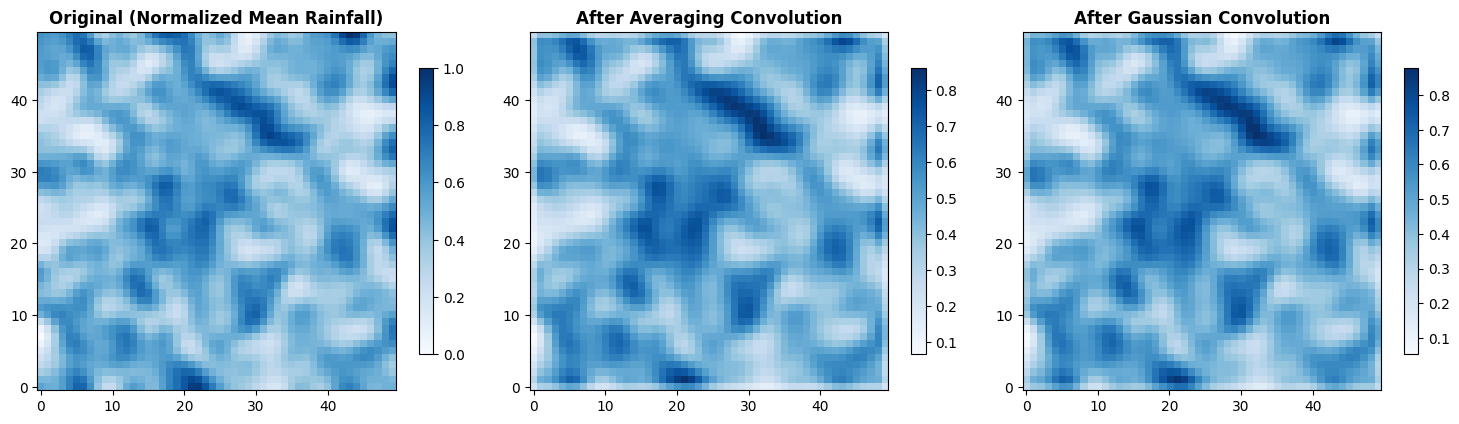

In [22]:
# Define convolution kernels
avg_kernel = np.ones((3, 3), dtype=np.float32) / 9.0
gaussian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float32) / 16.0

print("Averaging Kernel (3x3):\n", avg_kernel)
print("\nGaussian Kernel (3x3):\n", gaussian_kernel)

# Apply convolution using src function
input_band = tensor_normalized[0:1]
convolved_avg = apply_convolution(input_band, avg_kernel)
convolved_gaussian = apply_convolution(input_band, gaussian_kernel)

print(f"\nConvolution applied: {input_band.shape} -> {convolved_avg.shape}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(input_band[0], cmap='Blues', origin='lower')
axes[0].set_title('Original (Normalized Mean Rainfall)', fontweight='bold')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(convolved_avg[0], cmap='Blues', origin='lower')
axes[1].set_title('After Averaging Convolution', fontweight='bold')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

im3 = axes[2].imshow(convolved_gaussian[0], cmap='Blues', origin='lower')
axes[2].set_title('After Gaussian Convolution', fontweight='bold')
plt.colorbar(im3, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.show()

## 3.3 PyTorch Tensor Operations

Demonstrate native PyTorch tensor operations with GPU awareness.

PyTorch tensor: torch.Size([3, 50, 50]), dtype=torch.float32, device=cpu
GPU available: False
Conv2d: torch.Size([1, 1, 50, 50]) -> torch.Size([1, 1, 50, 50]) -> NumPy (50, 50)


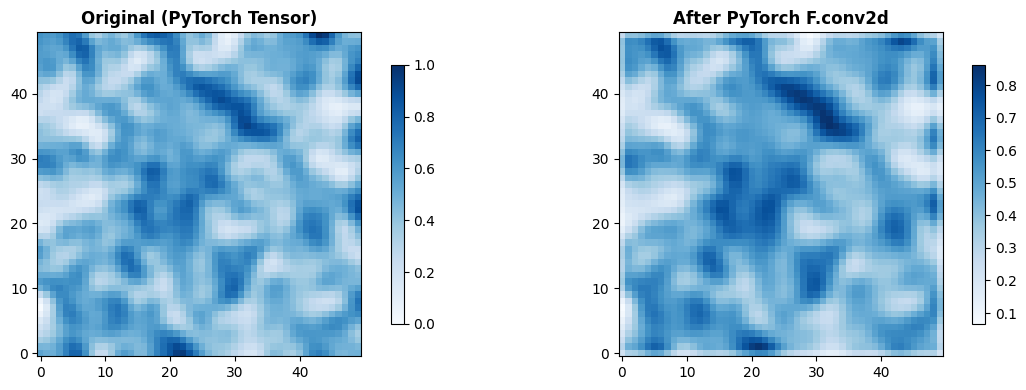


Pipeline complete: Raster -> NumPy -> Tensor -> Convolution -> NumPy


In [23]:
# Convert NumPy to PyTorch tensor
torch_tensor = torch.from_numpy(tensor_normalized).float()
print(f"PyTorch tensor: {torch_tensor.shape}, dtype={torch_tensor.dtype}, device={torch_tensor.device}")
print(f"GPU available: {torch.cuda.is_available()}")

# PyTorch convolution
input_4d = torch_tensor.unsqueeze(0)  # Add batch dimension: (1, C, H, W)
kernel_torch = torch.ones(1, 1, 3, 3) / 9.0

first_channel = input_4d[:, 0:1, :, :]
convolved_torch = F.conv2d(first_channel, kernel_torch, padding=1)
result_numpy = convolved_torch.squeeze().numpy()

print(f"Conv2d: {first_channel.shape} -> {convolved_torch.shape} -> NumPy {result_numpy.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im1 = axes[0].imshow(torch_tensor[0].numpy(), cmap='Blues', origin='lower')
axes[0].set_title('Original (PyTorch Tensor)', fontweight='bold')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

im2 = axes[1].imshow(result_numpy, cmap='Blues', origin='lower')
axes[1].set_title('After PyTorch F.conv2d', fontweight='bold')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

print("\nPipeline complete: Raster -> NumPy -> Tensor -> Convolution -> NumPy")

---
# Summary
---

## What was demonstrated:

### Section 1: Raster Data Cubes (Xarray)
- Loaded rainfall data cube as `xarray.Dataset`
- Explicit dimensions: **time**, **latitude**, **longitude**
- **Temporal aggregations**: mean, 95th percentile, coefficient of variation
- **Spatio-temporal slicing**: single year, multi-year, spatial subset
- Time series visualization from spatial aggregation

### Section 2: Raster Cube + Vector Interaction
- Created polygon zones (representing administrative units)
- Computed **zonal statistics**: mean, max, min, std rainfall per zone
- Demonstrated **cube → vector** integration using GeoPandas

### Section 3: Tensor Operations (PyTorch)
- Converted raster data to multi-band tensor using `create_geospatial_tensor()`
- Normalized tensor using `normalize_tensor()`
- Calculated statistics using `calculate_tensor_statistics()`
- Applied **convolution** using `apply_convolution()` (spatial influence spread)
- Demonstrated PyTorch native operations with GPU awareness
- Complete pipeline: **Raster → NumPy → Tensor → Operation → NumPy**